## Secure Key Distribution

In the digital age, secure communication is essential. To ensure that messages between two parties (let's call them Alice and Bob) remain private, they use encryption. Encryption relies on a **key**, a secret string of numbers that is used to encode and decode messages. However, sharing this key securely is a challenge. This process is called **key distribution**.

For example, imagine Alice wants to send a confidential message to Bob. If Eve (an eavesdropper) intercepts the key during transmission, she could decrypt Alice's messages without detection. Traditional methods of distributing keys often assume that Eve cannot access the key, but if she does, Alice and Bob might never know their communication has been compromised.

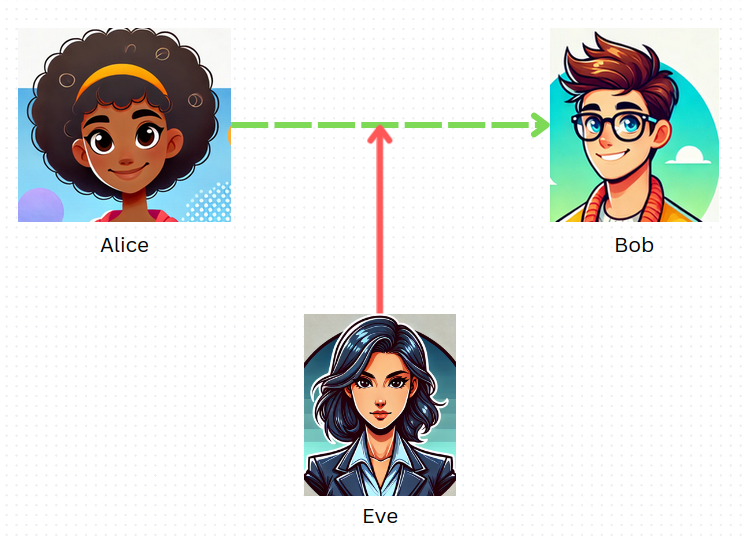

The question is: **How can Alice and Bob share a key in a way that guarantees its secrecy and detects any eavesdropping?**

---

## Quantum Key Distribution and the E91 Protocol

**Quantum Key Distribution (QKD)** uses the principles of quantum mechanics to address the challenges of secure key distribution. Unlike classical methods, QKD ensures that if an eavesdropper (Eve) tries to intercept the key, her presence will be detected.

The key insight comes from quantum mechanics: observing a quantum system disturbs it. In other words, Eve cannot intercept the quantum states used to transmit the key without introducing detectable anomalies. This fundamental property enables Alice and Bob to:

1. Share a key securely.
2. Detect any attempt by Eve to eavesdrop on their communication.

While our main topic is the E91 Protocol it is crucial to understand the BB84 Protocol on which it is based. So we will explain the BB84 Protocol in a short manner and highlight it's differnces to the E91 Protocol later on.

### The BB84 Protocol

Since Qubits are able to assume more positions than just 1 and 0 it is possible for Alice to send Bob information that is received by chance different on his end. In the BB84 Key Distribution Protocol Alice and Bob each measure in two different bases (green on Alice's side and blue/red on Bob's side). The bases are chosen at random so there is about a 1/3 chance both parties measure in the same basis.

In the illustration below you can see how Bob recevies a secret key from alice via Quantum Key Distribution without interception.

In real use-cases you will have to imagine that keys are normally much longer than 9 bits, for obvious security reasons.

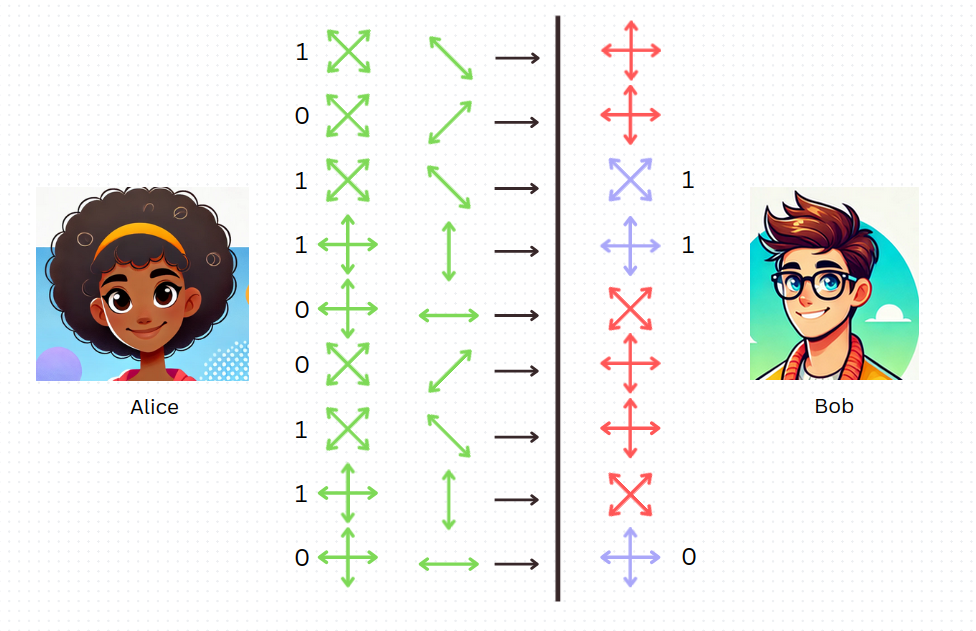

After transfering the information Alice and Bob will exchange their basis layout and compare. Bits measured in bases on Bob's side that are different from Alice's bases (the red marked bases) are discarded. Then from the remaining bits Alice and Bob pick a partial set and compare them. If there is an **eavesdropper** there is a high chance (growing the more bits you have to compare) that Bob will receive a bit, Alice sent, wrong.

Below you can view a code example for a **successfull** key exchange **without** an **eavesdropper**.


In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd

n = 10
seed = 42

computational_basis = 'Z'  # Z-Basis
hadamard_basis =      'X'  # X-Basis

# use seed for reliability
# np.random.seed(seed)

# choose bases of Alice and Bob at random
alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n) 
bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
alice_bits = np.random.randint(2, size=n)

aer_simulator = AerSimulator()

alice_results = []
bob_results = []

for i in range(n):
    qreg = QuantumRegister(2, f'q{i}')
    creg = ClassicalRegister(2, f'c{i}')
    circuit = QuantumCircuit(qreg, creg)
    
    circuit.h(qreg[0])
    circuit.cx(qreg[0], qreg[1])

    if alice_bases[i] == hadamard_basis:
        circuit.h(qreg[0])
    circuit.measure(qreg[0], creg[0])

    if bob_bases[i] == hadamard_basis:
        circuit.h(qreg[1])
    circuit.measure(qreg[1], creg[1])

    result = aer_simulator.run(circuit, shots=1).result()
    counts = result.get_counts()

    for outcome in counts:
        alice_results.append(int(outcome[-1]))
        bob_results.append(int(outcome[-2]))

# table 
matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]
key = [alice_results[i] for i in range(n) if matching_bases[i]]
data = {
    "Bits from Alice    ": alice_results,
    "  Bases from Alice    ": alice_bases,
    " ": [
        f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
        for i in range(n)
    ],
    "  Bits from Bob    ": bob_results,
    "  Bases from Bob    ": bob_bases,
    "    Matching Bits         ": [
        f"    \033[92m{alice_results[i]}\033[0m" if matching_bases[i] else f"\033[91m{bob_results[i]}\033[0m"
        for i in range(n)
    ],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

 Bits from Alice       Bases from Alice                            Bits from Bob       Bases from Bob         Matching Bits         
                   0                      Z     ----->                    1                    X                 1
                   1                      X     ----->                    1                    Z                 1
                   1                      X     ----->                    0                    Z                 0
                   1                      X     ----->                    1                    Z                 1
                   0                      X     ----->                    1                    Z                 1
                   1                      Z     ----->                    1                    Z                 1
                   1                      Z     ----->                    0                    X                 0
                   0                      Z     ----->        

In the table you generate above you can view how bits are transfered from Alice to Bob. You can change **n** at the start to repeat this code block with more or less bits. This will get especially interesting later on when adding Eve as an eavesdropper and comparing the BB84 Protocol to the E91 Protocol.

_As most security related matters, the more bits you add, the more sense this protocol makes._

---

There is a 25% chance per bit, that Alice and Bob use to check for an eavesdropper, that Eve can be detected. Below you can see how _(assuming you can not clone qubits or measure them in any other way without collapsing them from their superposition)_.

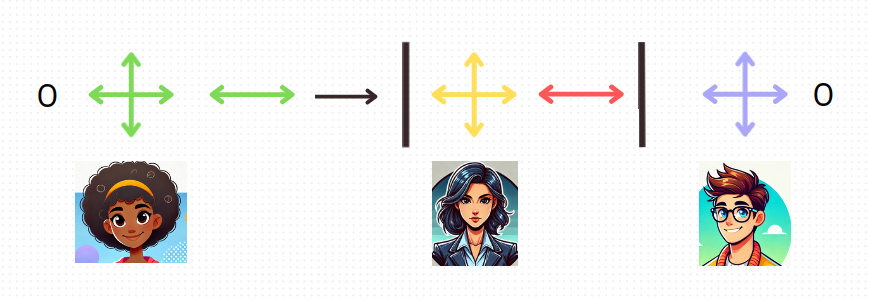

In this case Eve was lucky and measured with same basis as Bob (the Z-Basis). This is a **50%** chance that she is right.

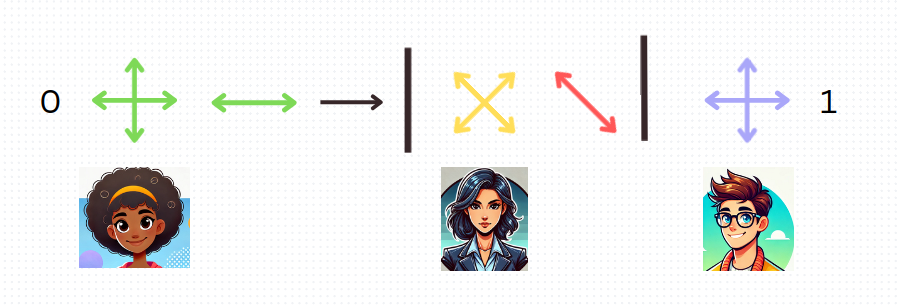

This case, where Eve measures the qubit sent by Alice with the **wrong basis** sets her up for failure. Since it arrives in a Superposition at Bob, he could with a **50%** chance _(again)_ measure the wrong bit. So if this bit is then used by Alice and Bob to check if they have been intercepted, Eve will be detected.

0.5 * 0.5 = 0.25, a **25%** chance on every bit _(that is used for checking)_ that Eve is detected.

Now we will modify the code shown earlier to show how this protocol plays out **with** an **eavesdropper**.

_Make sure to test changing the number of bits **'n'** and the number of repeats **repeats**._

In [5]:
def bb84_with_eavesdropper(n):
    # Alice, Bob und Eve
    alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    eve_bases = np.random.choice([hadamard_basis, computational_basis], size=n)

    aer_simulator = AerSimulator()

    alice_results = []
    bob_results = []
    eve_results = []
    eve_detected = []

    for i in range(n):
        qreg = QuantumRegister(1, f'q{i}')
        creg = ClassicalRegister(1, f'c{i}')
        circuit = QuantumCircuit(qreg, creg)

        # Alice präpariert Qubit
        if alice_bits[i] == 1:
            circuit.x(qreg[0])
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Eve misst
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])
        eve_result = aer_simulator.run(circuit, shots=1).result()
        eve_outcome = int(list(eve_result.get_counts().keys())[0][0])
        eve_results.append(eve_outcome)

        # Eve präpariert das Qubit neu
        if eve_outcome == 1:
            circuit.x(qreg[0])
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Bob misst
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        result = aer_simulator.run(circuit, shots=1).result()
        bob_outcome = int(list(result.get_counts().keys())[0][0])
        alice_results.append(alice_bits[i])
        bob_results.append(bob_outcome)

        # Detektionsprüfung
        eve_detected.append(
            alice_bases[i] == bob_bases[i] and alice_results[-1] != bob_results[-1]
        )

    matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]
    data = {
        "Bits from Alice    ": alice_results,
        "Bases from Alice    ": alice_bases,
        " ": [
            f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Bits from Eve       ": eve_results,
        "Bases from Eve      ": eve_bases,
        "  ": [
            f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Bits from Bob       ": bob_results,
        "Bases from Bob      ": bob_bases,
        "Matching Bits         ": [
            f"                         \033[92m{alice_results[i]}\033[0m" if matching_bases[i] else f"\033[91m{bob_results[i]}\033[0m"
            for i in range(n)
        ],
        "              Eve Detected?       ": ["Yes" if eve_detected[i] else "No" for i in range(n)],
    }

    df = pd.DataFrame(data)
    detected_rate = sum(eve_detected) / n * 100

    return df, detected_rate


# Simulation mit Wiederholungen
def run_simulation(n_bits, repeats):
    results = []
    detection_rates = []

    c = 0
    for _ in range(repeats):
        df, detected_rate = bb84_with_eavesdropper(n_bits)
        if detected_rate <= 0.0:
            c += 1
        results.append(df)
        detection_rates.append(detected_rate)

    avg_detection_rate = np.mean(detection_rates)

    # Anzeige des letzten Durchgangs
    print("\nLetzte Iteration:")
    print(results[-1].to_string(index=False))
    print(f"\nDurchschnittliche Entdeckungsrate über {repeats} Wiederholungen: {avg_detection_rate:.2f}%")
    print(f"Anzahl der Schlüsselaustausche ohne Eve zu bemerken: {c} von {repeats}")


n_bits = 10
repeats = 100
run_simulation(n_bits, repeats)


Letzte Iteration:
 Bits from Alice     Bases from Alice                          Bits from Eve        Bases from Eve                            Bits from Bob        Bases from Bob                    Matching Bits                        Eve Detected?       
                   0                    X     ----->                     0                    X     ----->                     0                    X                          0                                 No
                   1                    X     ----->                     1                    X     ----->                     0                    Z                          0                                 No
                   1                    X     ----->                     1                    X     ----->                     1                    Z                          1                                 No
                   0                    Z     ----->                     0                    Z     ----->